In [30]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0
import zipfile
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf


In [31]:
def extract_zip(filename):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        new_name = filename[:-4]
        print(new_name)
        zip_ref.extractall(new_name)
    return new_name


In [32]:
def extract_data(filename, hgt, wdt):
    img_list = []
    print(f'filename: {filename}')
    for images in os.listdir(f'{filename}/{filename}'):
        img = tf.io.read_file(f'{filename}/{filename}/{images}')
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (hgt,wdt))
        img = tf.cast(img / 255., tf.float32)
        img_list.append(img)
    return tf.stack(img_list, axis=0)

In [33]:
left_path = 'left' if os.path.isdir('left') else extract_zip('left.zip')
right_path = 'right' if os.path.isdir('right') else extract_zip('right.zip')
train_data = extract_data(left_path,28, 28).numpy()
test_data = extract_data(right_path, 28, 28).numpy()

left
filename: left
filename: right


In [34]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape


((18048, 28, 28, 1), (18048, 28, 28, 1))

In [35]:
train_data.dtype, test_data.dtype


(dtype('float32'), dtype('float32'))

In [36]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [37]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))


In [38]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [39]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [40]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         7385

In [41]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/50
113/113 [==============================] - 26s 226ms/step - loss: 0.0600 - val_loss: 0.0311

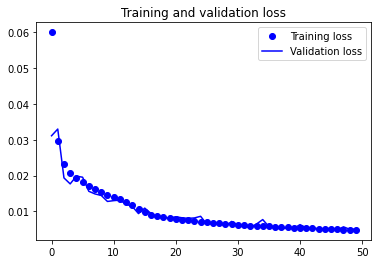

In [42]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [43]:
pred = autoencoder.predict(test_data)

564/564 [==============================] - 9s 15ms/step

Test Images
Reconstruction of Test Images


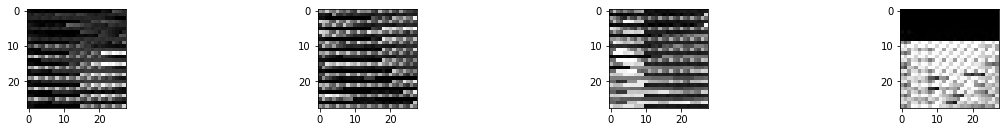

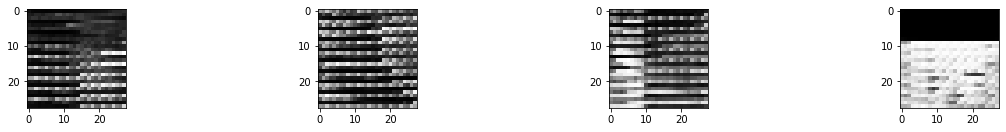

In [45]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
plt.show()
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')
plt.show()
